In [1]:
import sys
import os
import xarray as xr
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
import numpy as np
from isca_tools.utils.land import get_ocean_coords, get_land_coords
from isca_tools.utils import area_weighting, lat_lon_coord_slice, annual_mean, annual_time_slice
from isca_tools.land import write_land
from isca_tools.run.create_files import write_var

2025-02-07 15:54:59,197 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


## Read in bucket data from previous experiment
Reads 5 years of bucket depth info from previous experiment, and takes annual average.

In [2]:
exp_input = 'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/k=1/'
use_time_start = 360*2
ds_input = isca_tools.load_dataset(exp_input).bucket_depth.sel(time=slice(use_time_start, np.inf))
ds_input = annual_mean(ds_input).load()

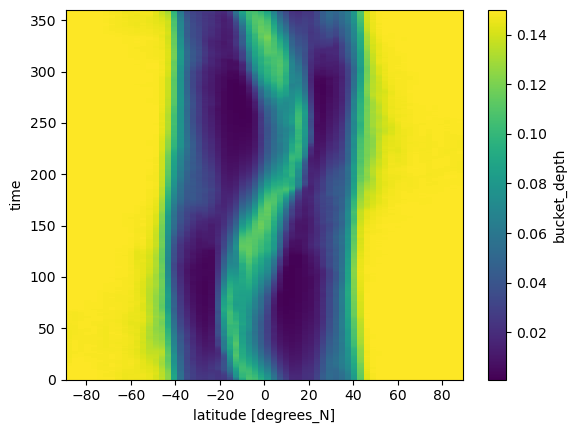

In [3]:
land_lon = slice(150, 210)
ds_input.sel(lon=land_lon).mean(dim='lon').plot()        # average over land longitudes

## Save bucket data to use for this experiment
The annual mean data shown above is what is used as the bucket depth for all years in the simulation. Below, we create this bucket depth *.nc* file.

In [46]:
# write above bucket depth to this experiment
exp_name = 'tau_sweep/land/meridional_band/bucket_file/evap=0_1/k=1/'
job_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/'
try:
    write_var('bucket', os.path.join(job_path, exp_name), var_array=ds_input.to_numpy(),
              lat_var=ds_input.lat.to_numpy(), lon_var=ds_input.lon.to_numpy(), time_var=np.round(ds_input.time.to_numpy()-0.5).astype(int),
              time_interpolate='wrap')      # so keeps alternating between 2 time coordinates in bucket_depth_input
except ValueError:
    print('bucket file already exists')
exp_name = [exp_name, exp_name.replace('k=1', 'k=1_5')]         # so when check simulation bucket depth, check both simulations
n_exp = len(exp_name)

bucket file already exists


### Sanity Check - Annual Zonal Mean Seasonal Cycle
Below, we confirm that the saved annual zonal mean variation is the same for each year, and is equal to the input bucket depth above.

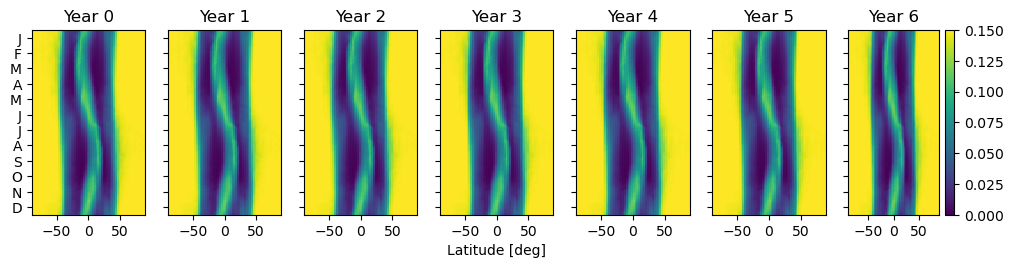

In [104]:
# Plot saved bucket depth
bucket_depth_saved = xr.load_dataset(os.path.join(job_path, exp_name[0])+'bucket.nc', decode_times=False).bucket
bucket_depth_saved = bucket_depth_saved.isel(time=slice(0, -1))     # remove last value as saved bucket depth has one more values than input
bucket_depth_saved_year = bucket_depth_saved.sel(lon=land_lon).groupby(np.floor(bucket_depth_saved.time/360))
n_years = len(bucket_depth_saved_year)

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
fig, ax = plt.subplots(1, n_years, figsize=(0.8*15, 0.8*3), sharex=True, sharey=True)
for i in range(n_years):
    im = ax[i].pcolormesh(ds_input.lat, ds_input.time, bucket_depth_saved_year[i].mean(dim='lon'), vmin=0, vmax=0.15)
    ax[i].set_title(f'Year {i}')
    if i==n_years-1:
        plt.colorbar(im, ax=ax[i])
ax[3].set_xlabel('Latitude [deg]')
ax[0].set_yticks(*month_ticks)
ax[0].invert_yaxis()
plt.show()

In [30]:
# Sanity check that each year is the same as input
[np.abs(bucket_depth_saved_year[i].mean(dim='lon').to_numpy() - ds_input.sel(lon=land_lon).mean(dim='lon').to_numpy()).max() for i in range(n_years)]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

### Sanity Check - Bucket depth is same on a given day for each year
Below, we confirm that any given day has the same bucket depth for all years.

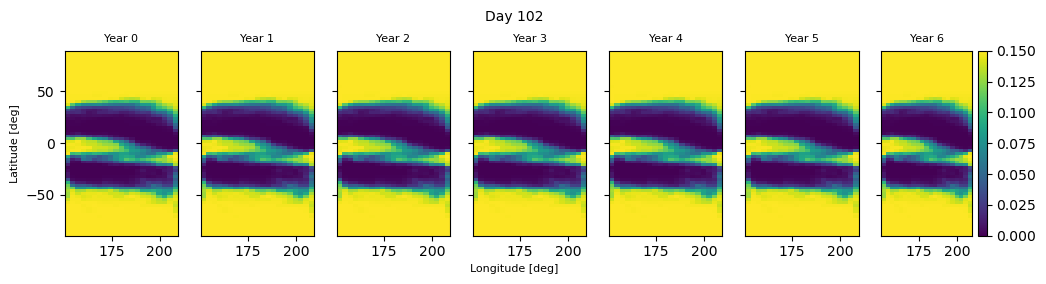

In [39]:
plot_day = 30*3+12
bucket_depth_saved_day = annual_time_slice(bucket_depth_saved, include_days=np.asarray([plot_day])).sel(lon=land_lon)
fig, ax = plt.subplots(1, n_years, figsize=(0.8*15, 0.8*3), sharex=True, sharey=True)
for i in range(n_years):
    im = ax[i].pcolormesh(bucket_depth_saved_day.lon, bucket_depth_saved_day.lat, bucket_depth_saved_day.isel(time=i), vmin=0, vmax=0.15)
    ax[i].set_title(f'Year {i}', fontsize=8)
    if i==n_years-1:
        plt.colorbar(im, ax=ax[i])
fig.suptitle(f'Day {plot_day}', fontsize=10, y=1.05)
ax[0].set_ylabel('Latitude [deg]', fontsize=8)
fig.supxlabel('Longitude [deg]', fontsize=8, y=-0.05)
plt.show()

In [40]:
# Sanity check that this day for each year is the same as input
[np.abs(bucket_depth_saved_day.isel(time=i).to_numpy() - ds_input.sel(lon=land_lon).isel(time=plot_day).to_numpy()).max() for i in range(n_years)]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## Check simulation has this bucket depth
Below, we repeat the above plots, but for the output of the simulation. This is to check that both $\kappa=1$ and $\kappa=1.5$ have same bucket depth as that set above.

The results are not exactly the same as above due to the averaging of multiple time steps into a single day, but they are very close, and for each year give the same result.

In [57]:
ds_sim =  [isca_tools.load_dataset(exp_name[i]).sel(lon=land_lon)[['bucket_depth', 't_surf']].load()
           for i in range(n_exp)]
ds_sim_year = [ds_sim[i].groupby(np.floor(ds_sim[i].time/360)) for i in range(n_exp)]

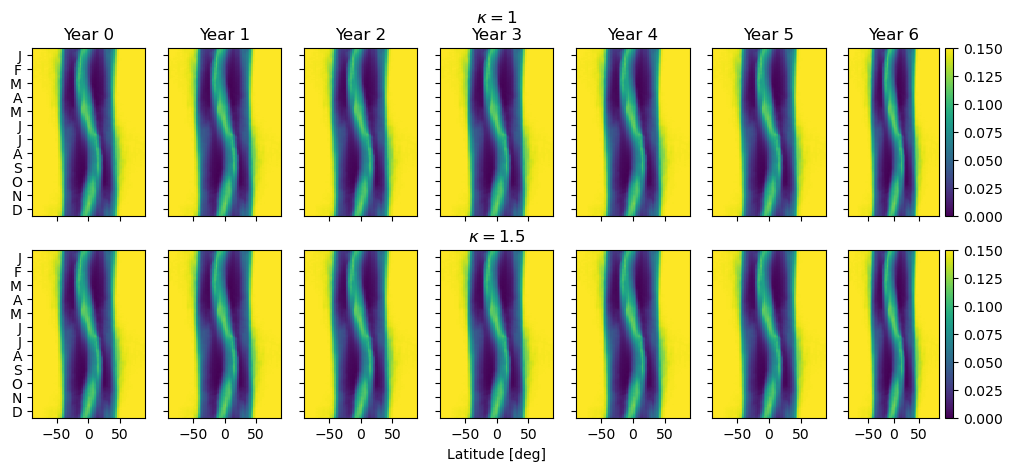

In [105]:
fig, ax = plt.subplots(2, n_years, figsize=(0.8*15, 2*0.8*3), sharex=True, sharey=True)
for i in range(n_years):
    for j in range(n_exp):
        im = ax[j, i].pcolormesh(ds_input.lat, ds_input.time, ds_sim_year[j][i].bucket_depth.mean(dim='lon'), vmin=0, vmax=0.15)
        if i==n_years-1:
            plt.colorbar(im, ax=ax[j, i])
        if j==0:
            if i==3:
                ax[j, i].set_title(f'$\kappa=1$\nYear {i}')
            else:
                ax[j, i].set_title(f'Year {i}')
        elif i==3:
            ax[j, i].set_title(f'$\kappa=1.5$')
ax[1, 3].set_xlabel('Latitude [deg]')
ax[0, 0].set_yticks(*month_ticks)
ax[0, 0].invert_yaxis()
plt.show()

In [86]:
# Sanity check that each year is the same as input
# Expect some difference, because simulation averages many time steps and outputs for single day
for j in range(n_exp):
    print(f'k={0.5*j+1}', [np.abs(ds_sim_year[j][i].bucket_depth.mean(dim='lon').to_numpy() -
                                  ds_input.sel(lon=land_lon).mean(dim='lon').to_numpy()).max() for i in range(n_years)])

k=1.0 [0.0036464334, 0.0036464334, 0.0036464334, 0.0036464334, 0.0036464334, 0.0036464334, 0.0036464334]
k=1.5 [0.0036464334, 0.0036464334, 0.0036464334, 0.0036464334, 0.0036464334, 0.0036464334, 0.0036464334]


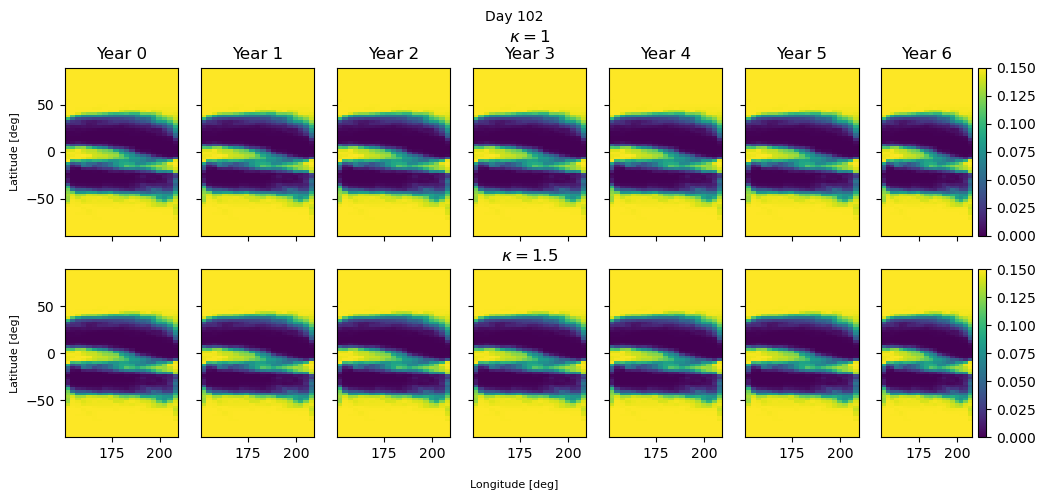

In [75]:
plot_day = 30*3+12
ds_sim_day = [annual_time_slice(ds_sim[i], include_days=np.asarray([plot_day])) for i in range(n_exp)]
fig, ax = plt.subplots(2, n_years, figsize=(0.8*15, 2*0.8*3), sharex=True, sharey=True)
for i in range(n_years):
    for j in range(n_exp):
        im = ax[j, i].pcolormesh(ds_sim_day[j].lon, ds_sim_day[j].lat, ds_sim_day[j].isel(time=i).bucket_depth, vmin=0, vmax=0.15)
        if i==n_years-1:
            plt.colorbar(im, ax=ax[j, i])
        if j==0:
            if i==3:
                ax[j, i].set_title(f'$\kappa=1$\nYear {i}')
            else:
                ax[j, i].set_title(f'Year {i}')
        elif i==3:
            ax[j, i].set_title(f'$\kappa=1.5$')
fig.suptitle(f'Day {plot_day}', fontsize=10, y=1.0)
ax[0, 0].set_ylabel('Latitude [deg]', fontsize=8)
ax[1, 0].set_ylabel('Latitude [deg]', fontsize=8)
fig.supxlabel('Longitude [deg]', fontsize=8, y=0)
plt.show()

In [94]:
# Sanity check that each day is the same as input
# Expect some difference, because simulation averages many time steps and outputs for single day
for j in range(n_exp):
    print(f'k={0.5*j+1}', [np.abs(ds_sim_day[j].isel(time=i).bucket_depth.to_numpy() -
                                  ds_input.sel(lon=land_lon).isel(time=plot_day).to_numpy()).max() for i in range(n_years)])

k=1.0 [0.004051745, 0.004051745, 0.004051745, 0.004051745, 0.004051745, 0.004051745, 0.004051745]
k=1.5 [0.004051745, 0.004051745, 0.004051745, 0.004051745, 0.004051745, 0.004051745, 0.004051745]


### Sanity Check - $\kappa=1.5$ is warmer than $\kappa=1$
Sanity check that the $\kappa=1.5$ simulation has larger `t_surf` than $\kappa=1$.

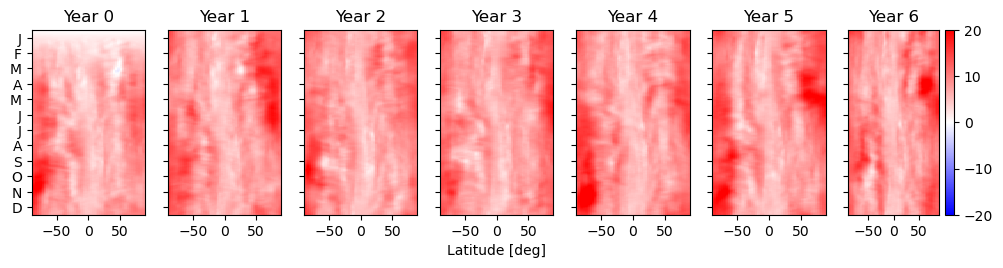

In [106]:
fig, ax = plt.subplots(1, n_years, figsize=(0.8*15, 0.8*3), sharex=True, sharey=True)
for i in range(n_years):
    im = ax[i].pcolormesh(ds_input.lat, ds_input.time, ds_sim_year[1][i].t_surf.mean(dim='lon') -
                             ds_sim_year[0][i].t_surf.mean(dim='lon'), vmin=-20, vmax=20, cmap='bwr')
    if i==n_years-1:
        plt.colorbar(im, ax=ax[i])
    ax[i].set_title(f'Year {i}')
ax[3].set_xlabel('Latitude [deg]')
ax[0].set_yticks(*month_ticks)
ax[0].invert_yaxis()
plt.show()